## Load the dataset

In [1]:
import numpy as np

In [11]:
dataset_path = '/home/ruifan/dataset/seizure/'

In [12]:
p1_train_path = dataset_path + 'p1train.npy'

In [13]:
p1_train = np.load(p1_train_path).item()

In [14]:
p1_filename = p1_train['file_name']
p1_label = p1_train['target']
p1_spec = p1_train['raw_spectrograms']

In [15]:
p1_train.keys()

['file_name', 'segment', 'target', 'raw_spectrograms']

## Load the safe label info

In [16]:
list_path = dataset_path + 'labels_safe.csv'

In [17]:
def generateSafeList(LIST_PATH):
    import pandas as pd
    df = pd.read_csv(dataset_path + 'labels_safe.csv')
    df_safe = df[df['safe'] == 1]
    return list(df_safe['image'])

In [18]:
safe_list = generateSafeList(list_path)
trindx = [fn in safe_list for fn in p1_train['file_name']]
safe_indx = np.where(trindx)

In [19]:
p1_label = p1_label[safe_indx]
p1_spec = p1_spec[safe_indx]

In [20]:
p1_spec.shape

(720, 16, 6, 10)

In [21]:
p1_label.shape

(720,)

In [22]:
p1_spec[0][0].shape

(6, 10)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [24]:
pre_list = np.random.choice(np.where(p1_label == 0)[0], 1)[0]
inter_list = np.random.choice(np.where(p1_label == 1)[0], 1)[0]

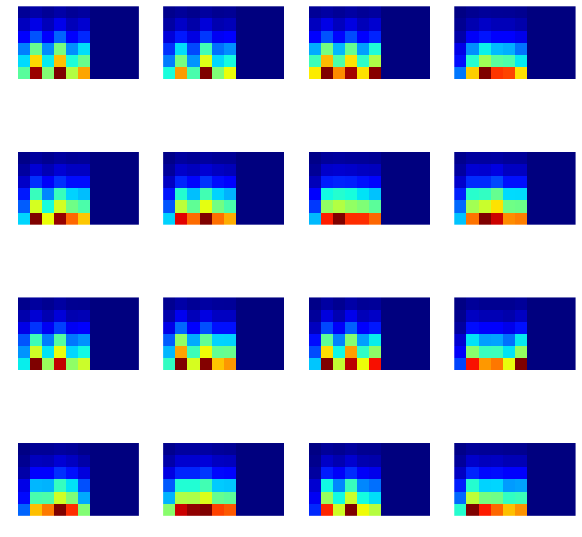

In [25]:
plt.figure(figsize=(10, 10))
for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    plt.imshow(p1_spec[pre_list][i], interpolation='None')
    plt.axis('off')
    

## Start using CNN to train model

In [26]:
# input spectrogram dimensions
img_rows, img_cols = 6, 10
# the channels of EEG data
img_channels = 16
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

batch_size = 32
nb_classes = 2
nb_epoch = 200

In [27]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


In [28]:
X = np.array([np.rot90(np.fliplr(np.rot90(i.T)), 2) for i in p1_spec])
y = p1_label

In [29]:
from sklearn import cross_validation

In [30]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=841)

In [31]:
X_train.shape

(504, 6, 10, 16)

In [32]:
y_train.shape

(504,)

In [33]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [34]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [35]:
model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

history = LossHistory()
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=2, shuffle=True, callbacks=[history], validation_data=(X_test, Y_test))

Train on 504 samples, validate on 216 samples
Epoch 1/200
0s - loss: 0.6153 - acc: 0.7599 - val_loss: 0.4822 - val_acc: 0.8102
Epoch 2/200
0s - loss: 0.5248 - acc: 0.7837 - val_loss: 0.5063 - val_acc: 0.8102
Epoch 3/200
0s - loss: 0.5225 - acc: 0.7837 - val_loss: 0.4638 - val_acc: 0.8102
Epoch 4/200
0s - loss: 0.5218 - acc: 0.7837 - val_loss: 0.4892 - val_acc: 0.8102
Epoch 5/200
0s - loss: 0.5124 - acc: 0.7837 - val_loss: 0.4996 - val_acc: 0.8102
Epoch 6/200
0s - loss: 0.5222 - acc: 0.7837 - val_loss: 0.4617 - val_acc: 0.8102
Epoch 7/200
0s - loss: 0.5090 - acc: 0.7837 - val_loss: 0.4466 - val_acc: 0.8102
Epoch 8/200
0s - loss: 0.5061 - acc: 0.7837 - val_loss: 0.4507 - val_acc: 0.8102
Epoch 9/200
0s - loss: 0.4923 - acc: 0.7837 - val_loss: 0.4426 - val_acc: 0.8102
Epoch 10/200
0s - loss: 0.5012 - acc: 0.7837 - val_loss: 0.4330 - val_acc: 0.8102
Epoch 11/200
0s - loss: 0.4761 - acc: 0.7817 - val_loss: 0.4741 - val_acc: 0.8102
Epoch 12/200
0s - loss: 0.4901 - acc: 0.7817 - val_loss: 0.43

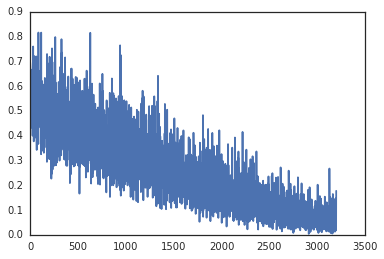

In [39]:
plt.plot(history.losses)

In [40]:
prediction_path = dataset_path + 'p1test.npy'
p1_predict = np.load(prediction_path).item()

In [41]:
p1_pred_filename = p1_predict['file_name']
p1_pred_spec = p1_predict['raw_spectrograms']

In [42]:
X_pred = np.array([np.rot90(np.fliplr(np.rot90(i.T)), 2) for i in p1_pred_spec])

In [44]:
p1_result = model.predict_proba(X_pred)

216/216 [==============================] - 0s     


In [45]:
p1_result

array([[  9.71681595e-01,   2.83184443e-02],
       [  9.92700160e-01,   7.29986513e-03],
       [  2.89261460e-01,   7.10738540e-01],
       [  9.42658246e-01,   5.73417395e-02],
       [  9.99994397e-01,   5.64654420e-06],
       [  9.99566495e-01,   4.33540583e-04],
       [  9.99931216e-01,   6.87271386e-05],
       [  9.71330464e-01,   2.86695138e-02],
       [  9.99580085e-01,   4.19903372e-04],
       [  9.99998212e-01,   1.79230540e-06],
       [  9.99678016e-01,   3.22042673e-04],
       [  9.33434606e-01,   6.65653497e-02],
       [  4.81745452e-01,   5.18254638e-01],
       [  8.80189955e-01,   1.19810045e-01],
       [  9.87122416e-01,   1.28775844e-02],
       [  9.95598555e-01,   4.40145191e-03],
       [  2.42862016e-01,   7.57138073e-01],
       [  2.66449362e-01,   7.33550668e-01],
       [  9.99070883e-01,   9.29105154e-04],
       [  9.59071279e-01,   4.09287326e-02],
       [  4.41505900e-03,   9.95584965e-01],
       [  9.60485578e-01,   3.95143963e-02],
       [  